### Import Modules

In [1]:
import numpy
from matplotlib import pyplot as plt
from matplotlib import rcParams

### Functions

In [2]:
def readpqr(filename, N):
    '''
    Reads a pqr file and returns the atom names, coordinates, and charges.    
    '''
    pqr_file = open(filename,'r')
    
    position = numpy.zeros((N,3))
    q = numpy.zeros(N)
    amino_acid_name = numpy.array(q, dtype=numpy.string_)
    atom_name = numpy.array(q, dtype=numpy.string_)
    chain = numpy.array(q, dtype=numpy.string_)
    amino_acid_number = numpy.zeros(N, dtype=int)
    
    counter = 0
    for i, line in enumerate(pqr_file):
        line_split = line.split()
        if line_split[0] == 'ATOM':
            position[counter,0] = float(line_split[6])
            position[counter,1] = float(line_split[7])
            position[counter,2] = float(line_split[8])
            q[counter] = float(line_split[9])
            amino_acid_name[counter] = line_split[3]
            amino_acid_number[counter] = int(line_split[5])
            atom_name[counter] = line_split[2]
            chain[counter] = line_split[4]
            counter += 1
        
    return position, q, amino_acid_name, amino_acid_number, atom_name,chain

def compute_force(dphi, q):
    '''
    Computes the electrostatic force on each atom due to the repulsion of the other atoms.
    '''
    
    force = -numpy.transpose(numpy.transpose(dphi)*q)
    force_magnitude = numpy.sqrt(numpy.sum(force**2, axis=1))
    
    total_force = numpy.sum(force, axis=0)
    total_force_magnitude = numpy.sqrt(numpy.sum(total_force**2))

    C0 = 69.467*4*numpy.pi*332.0636817823836
    return C0*force, C0*force_magnitude, C0*total_force, C0*total_force_magnitude

### Read dphir.txt files from Pygbe

In [3]:
folder='zika_afm\\tip_charge-2.5_rad150\\zatsc' #Folder containing dphir.txt files
dphi_386c = numpy.loadtxt(folder+'386/dphir.txt')   # d=0.2nm
#dphi_390c = numpy.loadtxt(folder+'390/dphir.txt')   # d=0.6nm
#dphi_394c = numpy.loadtxt(folder+'394/dphir.txt')   # d=1.0nm
#dphi_404c = numpy.loadtxt(folder+'404/dphir.txt')   # d=2.0nm
#dphi_484c = numpy.loadtxt(folder+'484/dphir.txt')   # d=10.0nm
dphi_1384c = numpy.loadtxt(folder+'1384/dphir.txt') # d=100.0nm
dphi_solo = numpy.loadtxt('zikaAlone/zikaAlone/dphir.txt')  # d=0.2nm

# Read pqr file and calculate forces
N = len(dphi_386c)
position, q, amino_acid_name, amino_acid_number, atom_name,chain = readpqr('zika_afm\\ZIKV_6CO8_aa_charge_vdw_addspace.pqr',N)
delta_dphi_386_local = dphi_386c - dphi_1384c
fqf_386, fqf_mag_386, Fqf_386, Fqf_mag_386 = compute_force(delta_dphi_386_local, q)
fqf_1384, fqf_mag_1384, Fqf_1384, Fqf_mag_1384 = compute_force(dphi_1384c, q)
fqf_solo, fqf_mag_solo, Fqf_solo, Fqf_mag_solo = compute_force(dphi_solo, q)

### Figure 3a)

Plane z = 0
Atoms with force greater than 1% of the total force:  159
Atoms displaced by more than +-0.5 Angstrom:  4599
Atoms displaced by more than +-2.5 Angstrom:  22883


<Figure size 432x288 with 0 Axes>

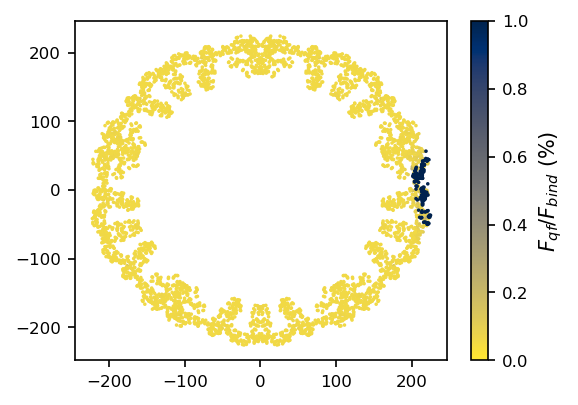

In [4]:
# Force qf plot for plane x-y (z=0) for capsid
# Select plane for the plot
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
plane = 0#-145.25
near_plane = numpy.where(abs(position[:,2]-plane)<0.5)[0] # Atoms between +-0.5 A
near_plane2 = numpy.where(abs(position[:,2]-plane)<2.5)[0] # Atoms between +-2.5 A
f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2) # Binding force magnitude


# Plotting
x = position[near_plane,0]
y = position[near_plane,1]
x2 = position[near_plane2,0]
y2 = position[near_plane2,1]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386) #Force percentage
f_porcent2 = 100*(fqf_mag_386[near_plane2])/(f_tot_mag_386) #Force percentage
f_greater  = numpy.where(f_porcent2 > 1)[0] #Detect forces greater than 1% of the total force

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(x,y,c=f_porcent,s=0.5, cmap='cividis_r',vmin=-0.3)
plt.scatter(x2[f_greater],y2[f_greater],c=f_porcent2[f_greater],cmap='cividis_r',s=0.5,vmin=0,vmax=1.0)
color = plt.colorbar(label=r'$F_{qf}/F_{bind}$ (%) ', )
plt.savefig('plots\\forces_qf_condelta_3a.pdf', format='pdf',dpi=300,bbox_inches='tight')

print('Plane z =', plane)
print('Atoms with force greater than 1% of the total force: ', len(f_greater))
print('Atoms displaced by more than +-0.5 Angstrom: ', len(near_plane))
print('Atoms displaced by more than +-2.5 Angstrom: ', len(near_plane2))

### Figure 3b)

Plane x = 210
Atoms between +-2.5 Angstrom: 8053


<Figure size 432x288 with 0 Axes>

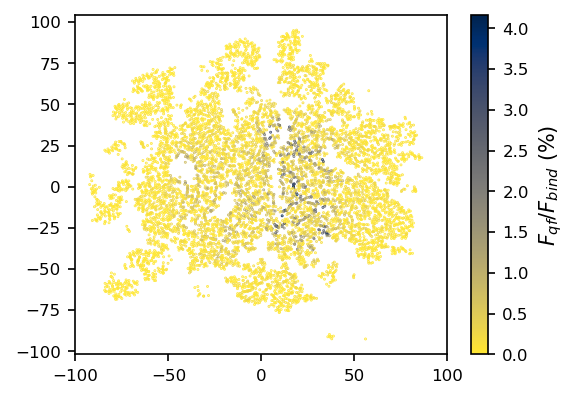

In [5]:
# Force qf plot for plane y-z (x=210) for capsid
# Select plane for the plot
plane = 210#-145.25
near_plane = numpy.where(abs(position[:,0]-plane)<2.5)[0]
f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2)

# Plotting
y = position[near_plane,1]
z = position[near_plane,2]
f_porcent = 100*(fqf_mag_386[near_plane])/(f_tot_mag_386)
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y,z,c=f_porcent,cmap='cividis_r',vmin=0,marker='.',s=0.5)
plt.colorbar(label=r'$F_{qf}/F_{bind}$ (%) ')
plt.xlim([-100,100])
plt.savefig('plots\\forces_qf_condelta_x={0}ang_3b.pdf'.format(plane), format='pdf',dpi=300,bbox_inches='tight')
print('Plane x =', plane)
print('Atoms between +-2.5 Angstrom:', len(near_plane))

### Figure 3c)

Plane x = 210


<Figure size 432x288 with 0 Axes>

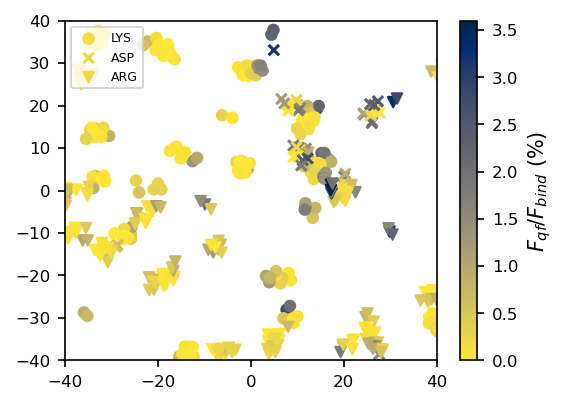

In [6]:
# identify amino acids names or chains
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

# Plotting for each chain
#ASN, ASP, GLY
plane = 210 #-145.25
near_plane_abs = numpy.where(abs(position[:,0]-plane)<2.5)[0] #Plane between +-1 angstrom
f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2)
near_plane_LYS = numpy.where(amino_acid_name[near_plane_abs] == b'LYS')[0] #Selecting atoms of the chain ASN
near_plane_ASP = numpy.where(amino_acid_name[near_plane_abs] == b'ASP')[0] #Selecting atoms of the chain ASP
near_plane_ARG = numpy.where(amino_acid_name[near_plane_abs] == b'ARG')[0] #Selecting atoms of the chain GLY

# Plotting
y_LYS = position[near_plane_abs[near_plane_LYS],1]
z_LYS = position[near_plane_abs[near_plane_LYS],2]
f_porcent_LYS = 100*(fqf_mag_386[near_plane_abs[near_plane_LYS]])/(f_tot_mag_386)
y_ASP = position[near_plane_abs[near_plane_ASP],1]
z_ASP = position[near_plane_abs[near_plane_ASP],2]
f_porcent_ASP = 100*(fqf_mag_386[near_plane_abs[near_plane_ASP]])/(f_tot_mag_386)
y_ARG = position[near_plane_abs[near_plane_ARG],1]
z_ARG = position[near_plane_abs[near_plane_ARG],2]
f_porcent_ARG = 100*(fqf_mag_386[near_plane_abs[near_plane_ARG]])/(f_tot_mag_386)


plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.scatter(y_LYS,z_LYS,c=f_porcent_LYS,s=25,cmap='cividis_r',marker='o',vmin=0,vmax=3.6)
plt.scatter(y_ASP,z_ASP,c=f_porcent_ASP,s=25,cmap='cividis_r',marker='x',vmin=0,vmax=3.6)
plt.scatter(y_ARG,z_ARG,c=f_porcent_ARG,s=25,cmap='cividis_r',marker='v',vmin=0,vmax=3.6)
plt.xlim([-40,40]); plt.ylim([-40,40])
plt.legend(['LYS','ASP','ARG'],loc='upper left',prop={'size': 6})
plt.colorbar(label=r'$F_{qf}/F_{bind}$ (%) ')
plt.savefig('plots_aminoacid\\forces_qf_condelta_x={0}ang_{1}_3c.pdf'.format(plane,'LYSASPARG'), format='pdf',dpi=300,bbox_inches='tight')
print('Plane x =', plane)

### Figure 4a)

<Figure size 432x288 with 0 Axes>

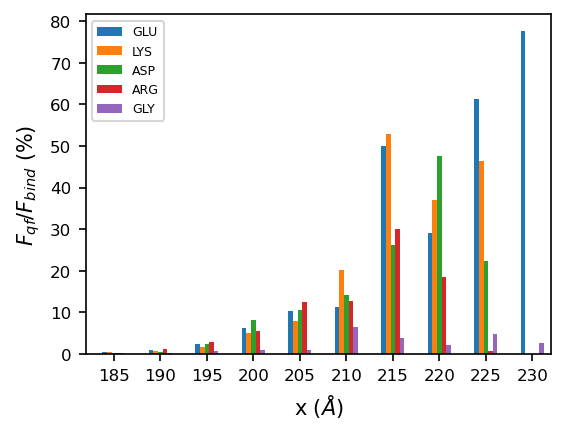

In [7]:
# identify amino acids names or chains
types = []
for j in range(amino_acid_name.shape[0]):
    if amino_acid_name[j] not in types:
        types.append(amino_acid_name[j])

def get_f_porcent_planes(x_min,x_max, h,  fqf_386, types, position, amino_acid_name):
    
    planes = numpy.arange(x_min,x_max,h) #Planes between +-h angstrom
    j = 0
    near_plane_chain = dict() 
    f_porcent_chain = dict()
    f_porcent_chain_mag = dict()
    #Set forces dictionary for each chain
    for chain in types:
        chain_name = chain.decode('utf-8')
        f_porcent_chain_mag[chain_name] = numpy.zeros(planes.shape)
        f_porcent_chain[chain_name] = numpy.zeros([int(planes.shape[0]),3])

    #Calculate forces between planes and chains
    for plane in planes:
        near_plane_abs = numpy.where(abs(position[:,0]-plane)<h/2)[0] #Plane between +-5 angstrom
        f_tot_mag_386 = numpy.sqrt((-2.1197685475579964)**2+(0.36092747252832624)**2+(0.00760169067022572)**2)
        for chain in types:
            chain_name = chain.decode('utf-8')
            near_plane_chain[chain_name] = numpy.where(amino_acid_name[near_plane_abs] == chain)[0] #Selecting atoms of the chain 
            f_porcent_chain[chain_name][j] = numpy.sum(fqf_386[near_plane_abs[near_plane_chain[chain_name]]],axis=0)
            f_porcent_chain_mag[chain_name][j] = 100*(numpy.sqrt(numpy.sum(f_porcent_chain[chain_name][j]**2)))/(f_tot_mag_386)
        j += 1
    return planes, f_porcent_chain, f_porcent_chain_mag

h=5
plt.rcParams['xtick.labelsize']=8
plt.rcParams['ytick.labelsize']=8
planes,f_porcent_chain, f_porcent_chain_mag = get_f_porcent_planes(-240,240,h,fqf_386,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, f_porcent_chain_mag['GLU'],width=h/10,label='GLU') 
plt.bar(planes-h/10, f_porcent_chain_mag['LYS'],width=h/10,label='LYS') 
plt.bar(planes, f_porcent_chain_mag['ASP'],width=h/10,label='ASP') 
plt.bar(planes+h/10, f_porcent_chain_mag['ARG'],width=h/10,label='ARG') 
plt.bar(planes+2*h/10, f_porcent_chain_mag['GLY'],width=h/10,label='GLY')
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf}/F_{bind}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots_aminoacid\\forces_qf_condelta_bar_{0}ang_4a.pdf'.format(h), format='pdf',dpi=300,bbox_inches='tight')
plt.show()


<Figure size 432x288 with 0 Axes>

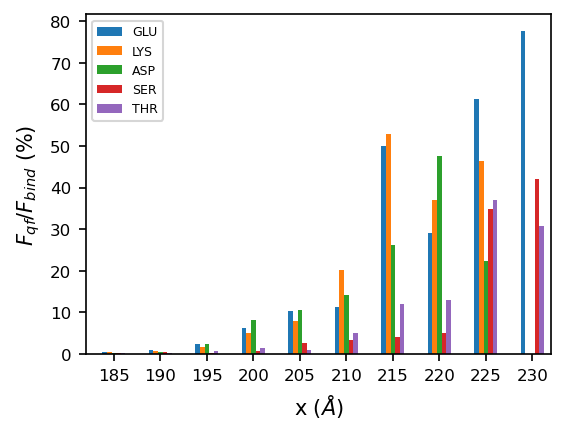

In [8]:
plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, f_porcent_chain_mag['GLU'],width=h/10,label='GLU') 
plt.bar(planes-h/10, f_porcent_chain_mag['LYS'],width=h/10,label='LYS') 
plt.bar(planes, f_porcent_chain_mag['ASP'],width=h/10,label='ASP') 
plt.bar(planes+h/10, f_porcent_chain_mag['SER'],width=h/10,label='SER') 
plt.bar(planes+2*h/10, f_porcent_chain_mag['THR'],width=h/10,label='THR')
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'$F_{qf}/F_{bind}$ (%) ')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots_aminoacid\\forces_qf_condelta_bar_{0}ang_4a2.pdf'.format(h), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

In [9]:
#Verification of the most important amino acids by force magnitude
f_porcent_chain_mag_sorted = sorted(f_porcent_chain_mag.items(), key=lambda x: max(x[1]), reverse=True)   

for chain, forces in f_porcent_chain_mag_sorted:
    print('Max force in chain %s: %.2f' %(chain,max(forces)))

Max force in chain GLU: 77.78
Max force in chain LYS: 52.89
Max force in chain ASP: 47.72
Max force in chain SER: 42.19
Max force in chain THR: 37.06
Max force in chain ARG: 30.09
Max force in chain ASN: 14.12
Max force in chain TYR: 9.64
Max force in chain ILE: 8.95
Max force in chain ALA: 8.58
Max force in chain GLY: 6.42
Max force in chain LEU: 6.34
Max force in chain PRO: 5.69
Max force in chain GLN: 5.65
Max force in chain CYX: 4.57
Max force in chain VAL: 3.35
Max force in chain MET: 3.14
Max force in chain PHE: 2.61
Max force in chain TRP: 2.22
Max force in chain HIE: 1.93
Max force in chain GLH: 0.26
Max force in chain ASH: 0.05
Max force in chain LYN: 0.03
Max force in chain CYS: 0.03


### Figure 4b)

In [10]:
#count amino_acid_name in the file
n_aminoacid = dict()
for aminoacid in types:
    aminoacid_name = aminoacid.decode('utf-8')
    n_aminoacid[aminoacid_name] = len(numpy.where(aminoacid == amino_acid_name)[0])

# sort by number of atoms in n_aminoacid
n_aminoacid_sorted = sorted(n_aminoacid.items(), key=lambda x: x[1], reverse=True)   
print('Total number of atoms:', len(atom_name))
print('Total number of amino acids atoms:', sum(n_aminoacid.values()))
n_aminoacid_sorted

Total number of atoms: 1576628
Total number of amino acids atoms: 1576628


[('LEU', 188100),
 ('LYS', 126632),
 ('VAL', 118080),
 ('THR', 115920),
 ('ARG', 99360),
 ('ILE', 96120),
 ('SER', 87300),
 ('ALA', 85140),
 ('GLU', 78180),
 ('GLY', 71820),
 ('PHE', 68400),
 ('MET', 58140),
 ('HIE', 58140),
 ('TRP', 56160),
 ('ASP', 53952),
 ('TYR', 49140),
 ('GLN', 48960),
 ('PRO', 47880),
 ('ASN', 45360),
 ('CYX', 21600),
 ('CYS', 1980),
 ('GLH', 128),
 ('LYN', 84),
 ('ASH', 52)]

<Figure size 432x288 with 0 Axes>

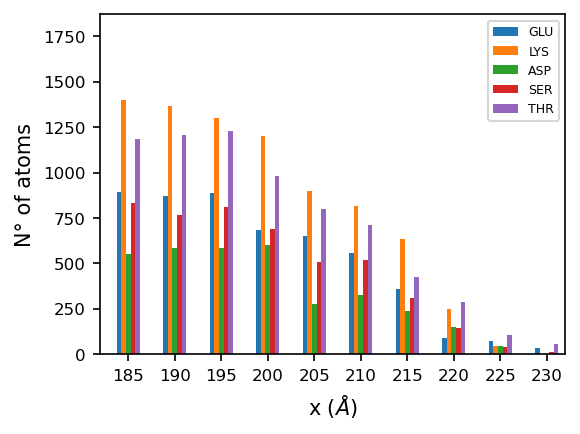

In [15]:
def get_atoms_aminoacid_planes(x_min,x_max, h, types, position, amino_acid_name):
    
    planes = numpy.arange(x_min,x_max,h) #Planes between +-h angstrom
    j = 0
    n_atoms = dict()
    #Set atoms dictionary for each chain
    for chain in types:
        chain_name = chain.decode('utf-8')
        n_atoms[chain_name] = numpy.zeros(planes.shape)

    #Calculate atoms between planes and chains
    for plane in planes:
        near_plane_abs = numpy.where(abs(position[:,0]-plane)<h/2)[0] #Plane between +-5 angstrom
        for chain in types:
            chain_name = chain.decode('utf-8')
            n_atoms[chain_name][j] = len(numpy.where(chain == amino_acid_name[near_plane_abs])[0])
        j += 1
    return planes, n_atoms

h= 5
planes, n_atoms = get_atoms_aminoacid_planes(-285,285,h,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes-2*h/10, n_atoms['GLU'],width=h/10,label='GLU') 
plt.bar(planes-h/10, n_atoms['LYS'],width=h/10,label='LYS') 
plt.bar(planes, n_atoms['ASP'],width=h/10,label='ASP') 
plt.bar(planes+h/10, n_atoms['SER'],width=h/10,label='SER') 
plt.bar(planes+2*h/10, n_atoms['THR'],width=h/10,label='THR')
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$')
plt.ylabel(r'N° of atoms')
plt.xticks(numpy.linspace(185,240,(240-185)//h +1))
plt.xlim([182,232])
plt.savefig('plots_aminoacid\\forces_qf_condelta_bar_{0}ang_4b.pdf'.format(h), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

### Figure 4) Extra

<Figure size 432x288 with 0 Axes>

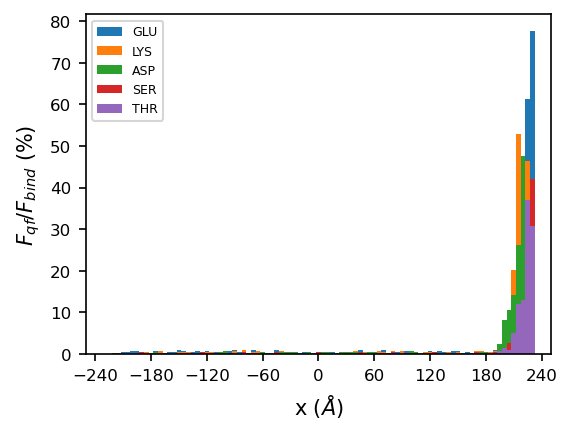

In [14]:
h= 5
planes, f_porcent_chain,f_porcent_chain_mag = get_f_porcent_planes(-285,285,h,fqf_386,types,position,amino_acid_name)

plt.clf()
plt.figure(figsize=(4,3),dpi=150)
plt.bar(planes, f_porcent_chain_mag['GLU'],width=h,label='GLU') 
plt.bar(planes, f_porcent_chain_mag['LYS'],width=h,label='LYS') 
plt.bar(planes, f_porcent_chain_mag['ASP'],width=h,label='ASP') 
plt.bar(planes, f_porcent_chain_mag['SER'],width=h,label='SER') 
plt.bar(planes, f_porcent_chain_mag['THR'],width=h,label='THR')
plt.legend(prop={'size': 6})
plt.xlabel('x $(\AA)$'); plt.ylabel(r'$F_{qf}/F_{bind}$ (%) ')
plt.xlim([-250,250]); plt.xticks(numpy.arange(-240,250,60))
plt.savefig('plots_aminoacid\\forces_qf_condelta_bar_{0}_4aextra.pdf'.format(str(h)), format='pdf',dpi=300,bbox_inches='tight')
plt.show()

In [13]:
#Verification of the most important amino acids by force magnitude
f_porcent_chain_mag_sorted = sorted(f_porcent_chain_mag.items(), key=lambda x: max(x[1]), reverse=True)   

for chain, forces in f_porcent_chain_mag_sorted:
    print('Max force in chain %s: %.2f' %(chain,max(forces)))

Max force in chain GLU: 77.78
Max force in chain LYS: 52.89
Max force in chain ASP: 47.72
Max force in chain SER: 42.19
Max force in chain THR: 37.06
Max force in chain ARG: 30.09
Max force in chain ASN: 14.12
Max force in chain TYR: 9.64
Max force in chain ILE: 8.95
Max force in chain ALA: 8.58
Max force in chain GLY: 6.42
Max force in chain LEU: 6.34
Max force in chain PRO: 5.69
Max force in chain GLN: 5.65
Max force in chain CYX: 4.57
Max force in chain VAL: 3.35
Max force in chain MET: 3.14
Max force in chain PHE: 2.61
Max force in chain TRP: 2.22
Max force in chain HIE: 1.93
Max force in chain GLH: 0.26
Max force in chain ASH: 0.05
Max force in chain LYN: 0.03
Max force in chain CYS: 0.03
